# 세상에서 가장 가벼운 단기 전력 수요 예측 모델

**1. 개요**
> - '과거의 패턴만으로 미래의 전력 수요 예측이 가능하다.'는 가설을 입증합니다.

**2. 모델 구성**
> - Model : CNN-LSTM, CNN-GRU 구성. 
> - Seq_len : 자기상관성 분석을 통해 얻은 최적의 값
> - Output_size : 타겟 기간
> - Input_Dim : 실험/대조군 피처 갯수
> - n_Layers : 3 (gridsearch result)
> - hidden dimension : 288(gridsearch result)

**3. 실험/대조군 설정**
> 1. Type 1 : 전력 수요 (baseline model)
> 2. Type 2 : 전력 수요, 달력
> 3. Type 3 : 전력 수요, 달력, 전력 수요 보조지표
> 4. Type 4 : 전력 수요, 달력, 날씨
> 5. Type 5 : 전력 수요, 달력. 날씨, 전력 수요 보조지표

**4. 분석 및 결과**
> - Type1(전력수요)을 제외한 모든 모델의 성능이 KPX (한국전력거래소 예측치)  대비 7%p 이상 높다.
>   - 전력데이터와 달력 데이터 만을 가지고 KPX모델을 대체 할 수 있다.
> - Type2(전력수요 + 달력)와 Type4(전력수요 + 달력 + 날씨)의 성능은 각각 3.29%, 3.50% 로 Type2의 성능이 6% 높다.
>   - 날씨 데이터의 추가는 성능 저하로 나타난다.
> - Type2(전력수요 + 날씨)와 Type3(전력수요 + 달력 + 보조지표)의 성능은 각각 3.29%, 3.26%로 동등하게 관찰된다.
>   - 달력데이터와 보조지표 조합은 성능 개선이 미미하다.
>    - 성능이 유사하다면, 경제성의 원리에 따라 Type2 모델이 적합하다.
> - Type5와 같이 전력수요 + 달력 + 날씨 + 보조지표로 함께 사용하게 된다면 최대 2.88%까지의 성능개선이 가능하다.

**5. 결론**
> - Type2의 입력인 전력수요 + 달력데이터 만으로도 기상정보를 사용하는것과 동등한 성능임을 검증하였습니다..
>    - 따라서 “과거의 패턴만으로 미래의 전력수요 예측이 가능하다”는 참입니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ls

drive  sample_data


In [3]:
!pip install torchmetrics -q
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import torchmetrics
from torchmetrics import MeanAbsolutePercentageError

In [4]:
print('pandas Version :', pd.__version__)
print('numpy Version :', np.__version__)
print('sklearn Version :', sklearn.__version__)
print('torch Version :', torch.__version__)
print('torchmetrics Version :', torchmetrics.__version__)

# in Colab
# pandas Version : 1.5.3
# numpy Version : 1.22.4
# sklearn Version : 1.2.2
# torch Version : 2.0.1+cu118
# torchmetrics Version : 0.11.4

pandas Version : 1.5.3
numpy Version : 1.24.3
sklearn Version : 1.2.2
torch Version : 2.0.1+cu118
torchmetrics Version : 0.11.4


In [5]:
random_seed = 222
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # multi-GPU

In [6]:
%cd /content/drive/MyDrive/DL Project/Final
from CLASS_FOR_FINAL import *

/content/drive/.shortcut-targets-by-id/1Q4ADZ6u630KufyxoZnmudQifavozrWNw/DL Project/Final


In [7]:
!ls

CLASS_FOR_FINAL.py     Final_data   Final_SJ.ipynb		 previous_model
CLASS_FOR_FINAL_SJ.py  Final.ipynb  power_demand_EDA_MAIN.ipynb  __pycache__
eda-data	       Final_model  previous_code		 results.csv


---

## ***Models***

### ***CNN_BiLSTM***

In [8]:
class CNN_BILSTM(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):
    super(CNN_BILSTM, self).__init__()
    # 입력인자 정의
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    # 합성곱 Layer 정의
    self.conv1d = nn.Conv1d(in_channels = self.in_channels, 
                            out_channels = self.out_channels,
                            kernel_size = self.kernel_size, 
                            padding = 'same')
    # LSTM Layer 정의
    self.lstm = nn.LSTM(self.out_channels, 
                        self.hidden_dim, 
                        num_layers = self.layers, 
                        batch_first = True, 
                        bidirectional = True)
    # 완전연결층 정의
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
  
  # 결과값 계산
  def forward(self, x):
    x = torch.transpose(x, 1, 2)
    x = self.conv1d(x)
    x = torch.transpose(x, 1, 2)
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

### ***CNN_BiGRU***

In [9]:
class CNN_BIGRU(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):
    super(CNN_BIGRU, self).__init__()
    # 입력인자 정의
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    # 합성곱 Layer 정의
    self.conv1d = nn.Conv1d(in_channels = self.in_channels, 
                            out_channels = self.out_channels,
                            kernel_size = self.kernel_size, 
                            padding = 'same')
    # GRU Layer 정의
    self.lstm = nn.GRU(self.out_channels, 
                       self.hidden_dim, 
                       num_layers = self.layers, 
                       batch_first = True, 
                       bidirectional = True)
    # 완전연결층 정의
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
  
  # 결과값 계산
  def forward(self, x):
    x = torch.transpose(x, 1, 2)
    x = self.conv1d(x)
    x = torch.transpose(x, 1, 2)
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

---

## ***Settings***

In [10]:
default_path = './Final_data/'
# default_path = '/content/drive/MyDrive/SJ_DL/Final/Final_data/'
weather_metadata_path = default_path + 'weather_localcenter_metadata.csv'
weather_5minute_ASOS_path = default_path + 'weather_5minute_ASOS_2020-2023.parquet'
holiday_path = default_path + 'holidays.csv'
power_path = default_path + 'power_demand_moving_avg_added.parquet'

In [11]:
# Basic Settings
# Input_Type                                | # Model
# Type_1 : Load                             | # CNN_BiLSTM
# Type_2 : Calendar + Load                  | # CNN_BiGRU
# Type_3 : Calendar + TA + Load             |
# Type_4 : Weather + Calendar + Load        |
# Type_5 : Weather + Calendar + TA + Load   |

---

### ***Train_Function***

In [12]:
# # 모델 학습 함수 만들기

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
#   optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#   nb_epochs = num_epochs
#   mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

#   # epoch마다 loss 저장
#   train_hist = np.zeros(nb_epochs)
#   output = []
  
#   for epoch in range(nb_epochs):
#     avg_cost = 0
#     total_batch = len(train_df)
#     for batch_idx, samples in enumerate(train_df):
#       x_train, y_train = samples
#       # seq별 hidden state reset
#       model.reset_hidden_state()
#       # H(x) 계산
#       outputs = model(x_train)
#       # cost 계산
#       loss = mean_abs_percentage_error(outputs, y_train)
#       # cost로 H(x) 개선
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       avg_cost += loss/total_batch 

#     train_hist[epoch] = avg_cost

#     if epoch % verbose == 0:
#       print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
#     # patience번째 마다 early stopping 여부 확인
#     if (epoch % patience == 0) & (epoch != 0):
#       if train_hist[epoch-patience] < train_hist[epoch]:
#         print('\n Early Stopping')
#         break
  
#   return model.eval(), train_hist

---

In [13]:
# cnn_bilstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, step_len, layers).to(device)
# cnn_bigru = CNN_BIGRU(in_channels, out_channels, kernel_size, hidden_dim, seq_len, step_len, layers).to(device)

# # Train
# # cnn_bilstm, cnn_bilstm_hist = train_model(cnn_bilstm, train_dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 1, patience = 4)
# # cnn_bigru, cnn_bigru_hist = train_model(cnn_bigru, train_dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 1, patience = 4)

---

### ***Validation***

---

In [14]:
# Basic Settings
# Input_Type                                | # Model
# Type_1 : Load                             | # CNN_BiLSTM
# Type_2 : Calendar + Load                  | # CNN_BiGRU
# Type_3 : Calendar + TA + Load             |
# Type_4 : Weather + Calendar + Load        |
# Type_5 : Weather + Calendar + TA + Load   |

In [15]:
# Preprocessing
type1 = Preprocessing(Input_type='Type_1')
device1 = type1.get_device()
DATA1 = type1.generate_target_df(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, power_path)
TRAIN1, VAL1, TEST1 = type1.split(DATA1)
del DATA1, VAL1

type2 = Preprocessing(Input_type='Type_2')
device2 = type2.get_device()
DATA2 = type2.generate_target_df(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, power_path)
TRAIN2, VAL2, TEST2 = type2.split(DATA2)
del DATA2, VAL2

type3 = Preprocessing(Input_type='Type_3')
device3 = type3.get_device()
DATA3 = type3.generate_target_df(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, power_path)
TRAIN3, VAL3, TEST3 = type3.split(DATA3)
del DATA3, VAL3

type4 = Preprocessing(Input_type='Type_4')
device4 = type4.get_device()
DATA4 = type4.generate_target_df(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, power_path)
TRAIN4, VAL4, TEST4 = type4.split(DATA4)
del DATA4, VAL4

type5 = Preprocessing(Input_type='Type_5')
device5 = type5.get_device()
DATA5 = type5.generate_target_df(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, power_path)
TRAIN5, VAL5, TEST5 = type5.split(DATA5)
del DATA5, VAL5

In [16]:
print('TEST1 Shape : ', TEST1.shape)
print('TEST2 Shape : ', TEST2.shape)
print('TEST3 Shape : ', TEST3.shape)
print('TEST4 Shape : ', TEST4.shape)
print('TEST5 Shape : ', TEST5.shape)

TEST1 Shape :  (4032, 2)
TEST2 Shape :  (4032, 56)
TEST3 Shape :  (4032, 67)
TEST4 Shape :  (4032, 59)
TEST5 Shape :  (4032, 70)


In [17]:
# MODEL_PATH = './Final_model/' # Local
MODEL_PATH = '/content/drive/MyDrive/DL Project/Final/Final_model/' # Colab

In [18]:
# Model Load
# map_location of model_load : 'cpu' => cpu로 로드함
type1_cnn_bilstm = model_load(Input_type='Type_1', Model='CNN_BiLSTM', path=MODEL_PATH)
type1_cnn_bigru = model_load(Input_type='Type_1', Model='CNN_BiGRU', path=MODEL_PATH)

type2_cnn_bilstm = model_load(Input_type='Type_2', Model='CNN_BiLSTM', path=MODEL_PATH)
type2_cnn_bigru = model_load(Input_type='Type_2', Model='CNN_BiGRU', path=MODEL_PATH)

type3_cnn_bilstm = model_load(Input_type='Type_3', Model='CNN_BiLSTM', path=MODEL_PATH)
type3_cnn_bigru = model_load(Input_type='Type_3', Model='CNN_BiGRU', path=MODEL_PATH)

type4_cnn_bilstm = model_load(Input_type='Type_4', Model='CNN_BiLSTM', path=MODEL_PATH)
type4_cnn_bigru = model_load(Input_type='Type_4', Model='CNN_BiGRU', path=MODEL_PATH)

type5_cnn_bilstm = model_load(Input_type='Type_5', Model='CNN_BiLSTM', path=MODEL_PATH)
type5_cnn_bigru = model_load(Input_type='Type_5', Model='CNN_BiGRU', path=MODEL_PATH)

In [19]:
print('type1_cnn_bilstm --------------------------------------------------------------------------------\n', type1_cnn_bilstm)
print('type1_cnn_bigru ---------------------------------------------------------------------------------\n', type1_cnn_bigru)
print('type2_cnn_bilstm --------------------------------------------------------------------------------\n', type2_cnn_bilstm)
print('type2_cnn_bigru ---------------------------------------------------------------------------------\n', type2_cnn_bigru)
print('type3_cnn_bilstm --------------------------------------------------------------------------------\n', type3_cnn_bilstm)
print('type3_cnn_bigru ---------------------------------------------------------------------------------\n', type3_cnn_bigru)
print('type4_cnn_bilstm --------------------------------------------------------------------------------\n', type4_cnn_bilstm)
print('type4_cnn_bigru ---------------------------------------------------------------------------------\n', type4_cnn_bigru)
print('type5_cnn_bilstm --------------------------------------------------------------------------------\n', type5_cnn_bilstm)
print('type5_cnn_bigru ---------------------------------------------------------------------------------\n', type5_cnn_bigru)

type1_cnn_bilstm --------------------------------------------------------------------------------
 CNN_BILSTM(
  (conv1d): Conv1d(1, 2, kernel_size=(5,), stride=(1,), padding=same)
  (lstm): LSTM(2, 288, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=576, out_features=2016, bias=True)
)
type1_cnn_bigru ---------------------------------------------------------------------------------
 CNN_BILSTM(
  (conv1d): Conv1d(1, 2, kernel_size=(5,), stride=(1,), padding=same)
  (lstm): GRU(2, 288, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=576, out_features=2016, bias=True)
)
type2_cnn_bilstm --------------------------------------------------------------------------------
 CNN_BILSTM(
  (conv1d): Conv1d(55, 110, kernel_size=(5,), stride=(1,), padding=same)
  (lstm): LSTM(110, 288, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=576, out_features=2016, bias=True)
)
type2_cnn_bigru --------------------

---

In [20]:
type1_cnn_bilstm = type1_cnn_bilstm.to(device1) 
type1_cnn_bigru = type1_cnn_bigru.to(device1)

type2_cnn_bilstm = type2_cnn_bilstm.to(device2) 
type2_cnn_bigru = type2_cnn_bigru.to(device2)

type3_cnn_bilstm = type3_cnn_bilstm.to(device3) 
type3_cnn_bigru = type3_cnn_bigru.to(device3)

type4_cnn_bilstm = type4_cnn_bilstm.to(device4) 
type4_cnn_bigru = type4_cnn_bigru.to(device4)

type5_cnn_bilstm = type5_cnn_bilstm.to(device5) 
type5_cnn_bigru = type5_cnn_bigru.to(device5)

In [21]:
# Type_1 Model Settings

in_channels_Type_1 = 1 # 입력 컬럼의 개수
out_channels_Type_1 = 2 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
kernel_size_Type_1 = 5 # 합성곱 필터의 커널의 크기
hidden_dim_Type_1 = 288 # 은닉 상태의 개수
layers_Type_1 = 3 # LSTM 혹은 GRU Layer의 개수
learning_rate_Type_1 = 0.0001 # 학습률
nb_epochs_Type_1 = 50 # 에포크의 수

# Type_2 Model Settings

in_channels_Type_2 = 55 # 입력 컬럼의 개수
out_channels_Type_2 = 110 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
kernel_size_Type_2 = 5 # 합성곱 필터의 커널의 크기
hidden_dim_Type_2 = 288 # 은닉 상태의 개수
layers_Type_2 = 3 # LSTM 혹은 GRU Layer의 개수
learning_rate_Type_2 = 0.0001 # 학습률
nb_epochs_Type_2 = 50 # 에포크의 수

# Type_3 Model Settings

in_channels_Type_3 = 66 # 입력 컬럼의 개수
out_channels_Type_3 = 132 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
kernel_size_Type_3 = 5 # 합성곱 필터의 커널의 크기
hidden_dim_Type_3 = 288 # 은닉 상태의 개수
layers_Type_3 = 3 # LSTM 혹은 GRU Layer의 개수
learning_rate_Type_3 = 0.0001 # 학습률
nb_epochs_Type_3 = 50 # 에포크의 수

# Type_4 Model Settings

in_channels_Type_4 = 58 # 입력 컬럼의 개수
out_channels_Type_4 = 116 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
kernel_size_Type_4 = 5 # 합성곱 필터의 커널의 크기
hidden_dim_Type_4 = 288 # 은닉 상태의 개수
layers_Type_4 = 3 # LSTM 혹은 GRU Layer의 개수
learning_rate_Type_4 = 0.0001 # 학습률
nb_epochs_Type_4 = 50 # 에포크의 수

# Type_5 Model Settings

in_channels_Type_5 = 69 # 입력 컬럼의 개수
out_channels_Type_5 = 138 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
kernel_size_Type_5 = 5 # 합성곱 필터의 커널의 크기
hidden_dim_Type_5 = 288 # 은닉 상태의 개수
layers_Type_5 = 3 # LSTM 혹은 GRU Layer의 개수
learning_rate_Type_5 = 0.0001 # 학습률
nb_epochs_Type_5 = 50 # 에포크의 수

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
# # CustomDataset Settings

seq_len = 2016 # 시퀀스의 길이
step_len = 2016 # 스텝 사이즈
binary_dict = {'Type_1' : 1, 'Type_2' : 1, 'Type_3' : 12, 'Type_4' : 4, 'Type_5' : 15}
binary_start_cols_Type_1 = binary_dict['Type_1']
binary_start_cols_Type_2 = binary_dict['Type_2']
binary_start_cols_Type_3 = binary_dict['Type_3']
binary_start_cols_Type_4 = binary_dict['Type_4']
binary_start_cols_Type_5 = binary_dict['Type_5']

ss_11 = MinMaxScaler() # Scaler for X
ss_12 = MinMaxScaler() # Scaler for y
ss_21 = MinMaxScaler() # Scaler for X
ss_22 = MinMaxScaler() # Scaler for y
ss_31 = MinMaxScaler() # Scaler for X
ss_32 = MinMaxScaler() # Scaler for y
ss_41 = MinMaxScaler() # Scaler for X
ss_42 = MinMaxScaler() # Scaler for y
ss_51 = MinMaxScaler() # Scaler for X
ss_52 = MinMaxScaler() # Scaler for y

TRAIN1_Dataset = CustomDatasetForTrain(TRAIN1, binary_start_cols_Type_1, ss_11, ss_12, seq_len, step_len, stride = 1, device=device)
TRAIN2_Dataset = CustomDatasetForTrain(TRAIN2, binary_start_cols_Type_2, ss_21, ss_22, seq_len, step_len, stride = 1, device=device)
TRAIN3_Dataset = CustomDatasetForTrain(TRAIN3, binary_start_cols_Type_3, ss_31, ss_32, seq_len, step_len, stride = 1, device=device)
TRAIN4_Dataset = CustomDatasetForTrain(TRAIN4, binary_start_cols_Type_4, ss_41, ss_42, seq_len, step_len, stride = 1, device=device)
TRAIN5_Dataset = CustomDatasetForTrain(TRAIN5, binary_start_cols_Type_5, ss_51, ss_52, seq_len, step_len, stride = 1, device=device)

TRAIN1_DataLoader = DataLoader(TRAIN1_Dataset, batch_size = 256, shuffle = True, drop_last = True)
TRAIN2_DataLoader = DataLoader(TRAIN2_Dataset, batch_size = 256, shuffle = True, drop_last = True)
TRAIN3_DataLoader = DataLoader(TRAIN3_Dataset, batch_size = 256, shuffle = True, drop_last = True)
TRAIN4_DataLoader = DataLoader(TRAIN4_Dataset, batch_size = 256, shuffle = True, drop_last = True)
TRAIN5_DataLoader = DataLoader(TRAIN5_Dataset, batch_size = 256, shuffle = True, drop_last = True)

TEST1_Dataset = CustomDatasetForValTest(TEST1, binary_start_cols_Type_1, ss_11, ss_12, seq_len, step_len, stride = 1, device=device)
TEST2_Dataset = CustomDatasetForValTest(TEST2, binary_start_cols_Type_2, ss_21, ss_22, seq_len, step_len, stride = 1, device=device)
TEST3_Dataset = CustomDatasetForValTest(TEST3, binary_start_cols_Type_3, ss_31, ss_32, seq_len, step_len, stride = 1, device=device)
TEST4_Dataset = CustomDatasetForValTest(TEST4, binary_start_cols_Type_4, ss_41, ss_42, seq_len, step_len, stride = 1, device=device)
TEST5_Dataset = CustomDatasetForValTest(TEST5, binary_start_cols_Type_5, ss_51, ss_52, seq_len, step_len, stride = 1, device=device)

TEST1_DataLoader = DataLoader(TEST1_Dataset, batch_size = 1, shuffle = False, drop_last = True)
TEST2_DataLoader = DataLoader(TEST2_Dataset, batch_size = 1, shuffle = False, drop_last = True)
TEST3_DataLoader = DataLoader(TEST3_Dataset, batch_size = 1, shuffle = False, drop_last = True)
TEST4_DataLoader = DataLoader(TEST4_Dataset, batch_size = 1, shuffle = False, drop_last = True)
TEST5_DataLoader = DataLoader(TEST5_Dataset, batch_size = 1, shuffle = False, drop_last = True)

---

In [24]:
# Type_1

with torch.no_grad():
  
  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnn_bilstm_pred_list_val_Type_1 = []
  cnn_bigru_pred_list_val_Type_1 = []
  true_list_val_Type_1 = []

  for X, y in TEST1_DataLoader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    cnn_bilstm_pred = type1_cnn_bilstm(X)
    cnn_bigru_pred = type1_cnn_bigru(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnn_bilstm_pred_list_val_Type_1.append(ss_12.inverse_transform(cnn_bilstm_pred.cpu().detach().numpy()))
    cnn_bigru_pred_list_val_Type_1.append(ss_12.inverse_transform(cnn_bigru_pred.cpu().detach().numpy()))
    true_list_val_Type_1.append(ss_12.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnn_bilstm_MAPE_list_val_Type_1 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bilstm_pred_list_val_Type_1, true_list_val_Type_1)]
cnnbigru_MAPE_list_val_Type_1 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bigru_pred_list_val_Type_1, true_list_val_Type_1)]

# 모델별 평균 MAPE 출력하기
print('Type_1 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_1)/len(cnn_bilstm_MAPE_list_val_Type_1) * 100, 3)))
print('Type_1 CNN + Bi-GRU 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_1)/len(cnnbigru_MAPE_list_val_Type_1) * 100, 3)))

Type_1 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 13.094% 입니다
Type_1 CNN + Bi-GRU 모델의 평균 검증 MAPE는 8.749% 입니다


In [25]:
# Type_2

with torch.no_grad():
  
  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnn_bilstm_pred_list_val_Type_2 = []
  cnn_bigru_pred_list_val_Type_2 = []
  true_list_val_Type_2 = []

  for X, y in TEST2_DataLoader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    cnn_bilstm_pred = type2_cnn_bilstm(X)
    cnn_bigru_pred = type2_cnn_bigru(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnn_bilstm_pred_list_val_Type_2.append(ss_22.inverse_transform(cnn_bilstm_pred.cpu().detach().numpy()))
    cnn_bigru_pred_list_val_Type_2.append(ss_22.inverse_transform(cnn_bigru_pred.cpu().detach().numpy()))
    true_list_val_Type_2.append(ss_22.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnn_bilstm_MAPE_list_val_Type_2 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bilstm_pred_list_val_Type_2, true_list_val_Type_2)]
cnnbigru_MAPE_list_val_Type_2 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bigru_pred_list_val_Type_2, true_list_val_Type_2)]

# 모델별 평균 MAPE 출력하기
print('Type_2 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_2)/len(cnn_bilstm_MAPE_list_val_Type_2) * 100, 3)))
print('Type_2 CNN + Bi-GRU 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_2)/len(cnnbigru_MAPE_list_val_Type_2) * 100, 3)))

Type_2 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 3.292% 입니다
Type_2 CNN + Bi-GRU 모델의 평균 검증 MAPE는 3.383% 입니다


In [26]:
# Type_3

with torch.no_grad():
  
  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnn_bilstm_pred_list_val_Type_3 = []
  cnn_bigru_pred_list_val_Type_3 = []
  true_list_val_Type_3 = []

  for X, y in TEST3_DataLoader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    cnn_bilstm_pred = type3_cnn_bilstm(X)
    cnn_bigru_pred = type3_cnn_bigru(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnn_bilstm_pred_list_val_Type_3.append(ss_32.inverse_transform(cnn_bilstm_pred.cpu().detach().numpy()))
    cnn_bigru_pred_list_val_Type_3.append(ss_32.inverse_transform(cnn_bigru_pred.cpu().detach().numpy()))
    true_list_val_Type_3.append(ss_32.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnn_bilstm_MAPE_list_val_Type_3 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bilstm_pred_list_val_Type_3, true_list_val_Type_3)]
cnnbigru_MAPE_list_val_Type_3 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bigru_pred_list_val_Type_3, true_list_val_Type_3)]

# 모델별 평균 MAPE 출력하기
print('Type_3 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_3)/len(cnn_bilstm_MAPE_list_val_Type_3) * 100, 3)))
print('Type_3 CNN + Bi-GRU 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_3)/len(cnnbigru_MAPE_list_val_Type_3) * 100, 3)))

Type_3 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 3.262% 입니다
Type_3 CNN + Bi-GRU 모델의 평균 검증 MAPE는 3.484% 입니다


In [27]:
# Type_4

with torch.no_grad():
  
  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnn_bilstm_pred_list_val_Type_4 = []
  cnn_bigru_pred_list_val_Type_4 = []
  true_list_val_Type_4 = []

  for X, y in TEST4_DataLoader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    cnn_bilstm_pred = type4_cnn_bilstm(X)
    cnn_bigru_pred = type4_cnn_bigru(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnn_bilstm_pred_list_val_Type_4.append(ss_42.inverse_transform(cnn_bilstm_pred.cpu().detach().numpy()))
    cnn_bigru_pred_list_val_Type_4.append(ss_42.inverse_transform(cnn_bigru_pred.cpu().detach().numpy()))
    true_list_val_Type_4.append(ss_42.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnn_bilstm_MAPE_list_val_Type_4 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bilstm_pred_list_val_Type_4, true_list_val_Type_4)]
cnnbigru_MAPE_list_val_Type_4 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bigru_pred_list_val_Type_4, true_list_val_Type_4)]

# 모델별 평균 MAPE 출력하기
print('Type_4 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_4)/len(cnn_bilstm_MAPE_list_val_Type_4) * 100, 3)))
print('Type_4 CNN + Bi-GRU 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_4)/len(cnnbigru_MAPE_list_val_Type_4) * 100, 3)))

Type_4 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 3.504% 입니다
Type_4 CNN + Bi-GRU 모델의 평균 검증 MAPE는 3.803% 입니다


In [28]:
# Type_5

with torch.no_grad():
  
  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnn_bilstm_pred_list_val_Type_5 = []
  cnn_bigru_pred_list_val_Type_5 = []
  true_list_val_Type_5 = []

  for X, y in TEST5_DataLoader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    cnn_bilstm_pred = type5_cnn_bilstm(X)
    cnn_bigru_pred = type5_cnn_bigru(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnn_bilstm_pred_list_val_Type_5.append(ss_52.inverse_transform(cnn_bilstm_pred.cpu().detach().numpy()))
    cnn_bigru_pred_list_val_Type_5.append(ss_52.inverse_transform(cnn_bigru_pred.cpu().detach().numpy()))
    true_list_val_Type_5.append(ss_52.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnn_bilstm_MAPE_list_val_Type_5 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bilstm_pred_list_val_Type_5, true_list_val_Type_5)]
cnnbigru_MAPE_list_val_Type_5 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bigru_pred_list_val_Type_5, true_list_val_Type_5)]

# 모델별 평균 MAPE 출력하기
print('Type_5 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_5)/len(cnn_bilstm_MAPE_list_val_Type_5) * 100, 3)))
print('Type_5 CNN + Bi-GRU 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_5)/len(cnnbigru_MAPE_list_val_Type_5) * 100, 3)))

Type_5 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 2.88% 입니다
Type_5 CNN + Bi-GRU 모델의 평균 검증 MAPE는 4.778% 입니다


In [29]:
print('Type_1 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_1)/len(cnn_bilstm_MAPE_list_val_Type_1) * 100, 3)))
print('Type_1 CNN + Bi-GRU  모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_1)/len(cnnbigru_MAPE_list_val_Type_1) * 100, 3)))
print('Type_2 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_2)/len(cnn_bilstm_MAPE_list_val_Type_2) * 100, 3)))
print('Type_2 CNN + Bi-GRU  모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_2)/len(cnnbigru_MAPE_list_val_Type_2) * 100, 3)))
print('Type_3 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_3)/len(cnn_bilstm_MAPE_list_val_Type_3) * 100, 3)))
print('Type_3 CNN + Bi-GRU  모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_3)/len(cnnbigru_MAPE_list_val_Type_3) * 100, 3)))
print('Type_4 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_4)/len(cnn_bilstm_MAPE_list_val_Type_4) * 100, 3)))
print('Type_4 CNN + Bi-GRU  모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_4)/len(cnnbigru_MAPE_list_val_Type_4) * 100, 3)))
print('Type_5 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnn_bilstm_MAPE_list_val_Type_5)/len(cnn_bilstm_MAPE_list_val_Type_5) * 100, 3)))
print('Type_5 CNN + Bi-GRU  모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val_Type_5)/len(cnnbigru_MAPE_list_val_Type_5) * 100, 3)))

Type_1 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 13.094% 입니다
Type_1 CNN + Bi-GRU  모델의 평균 검증 MAPE는 8.749% 입니다
Type_2 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 3.292% 입니다
Type_2 CNN + Bi-GRU  모델의 평균 검증 MAPE는 3.383% 입니다
Type_3 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 3.262% 입니다
Type_3 CNN + Bi-GRU  모델의 평균 검증 MAPE는 3.484% 입니다
Type_4 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 3.504% 입니다
Type_4 CNN + Bi-GRU  모델의 평균 검증 MAPE는 3.803% 입니다
Type_5 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 2.88% 입니다
Type_5 CNN + Bi-GRU  모델의 평균 검증 MAPE는 4.778% 입니다


---

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [31]:
results = pd.DataFrame(list(zip(
                true_list_val_Type_5[0][0], 
                cnn_bilstm_pred_list_val_Type_1[0][0],
                cnn_bigru_pred_list_val_Type_1[0][0],
                cnn_bilstm_pred_list_val_Type_2[0][0],
                cnn_bigru_pred_list_val_Type_2[0][0],
                cnn_bilstm_pred_list_val_Type_3[0][0],
                cnn_bigru_pred_list_val_Type_3[0][0],
                cnn_bilstm_pred_list_val_Type_4[0][0],
                cnn_bigru_pred_list_val_Type_4[0][0],
                cnn_bilstm_pred_list_val_Type_5[0][0],
                cnn_bigru_pred_list_val_Type_5[0][0],
                )))
results.columns = ['Label',
                  'Type_1 CNN_LSTM',
                  'Type_1 CNN_GRU',
                  'Type_2 CNN_LSTM',
                  'Type_2 CNN_GRU',
                  'Type_3 CNN_LSTM',
                  'Type_3 CNN_GRU',
                  'Type_4 CNN_LSTM',
                  'Type_4 CNN_GRU',
                  'Type_5 CNN_LSTM',
                  'Type_5 CNN_GRU',
                ]
results['Time'] = (pd.date_range('2023-03-13', '2023-03-20', freq='5min'))[:-1]
results = results[['Time',
                  'Label',
                  'Type_1 CNN_LSTM',
                  'Type_1 CNN_GRU',
                  'Type_2 CNN_LSTM',
                  'Type_2 CNN_GRU',
                  'Type_3 CNN_LSTM',
                  'Type_3 CNN_GRU',
                  'Type_4 CNN_LSTM',
                  'Type_4 CNN_GRU',
                  'Type_5 CNN_LSTM',
                  'Type_5 CNN_GRU',
                ]]

## ***Graphs***

### ***All***

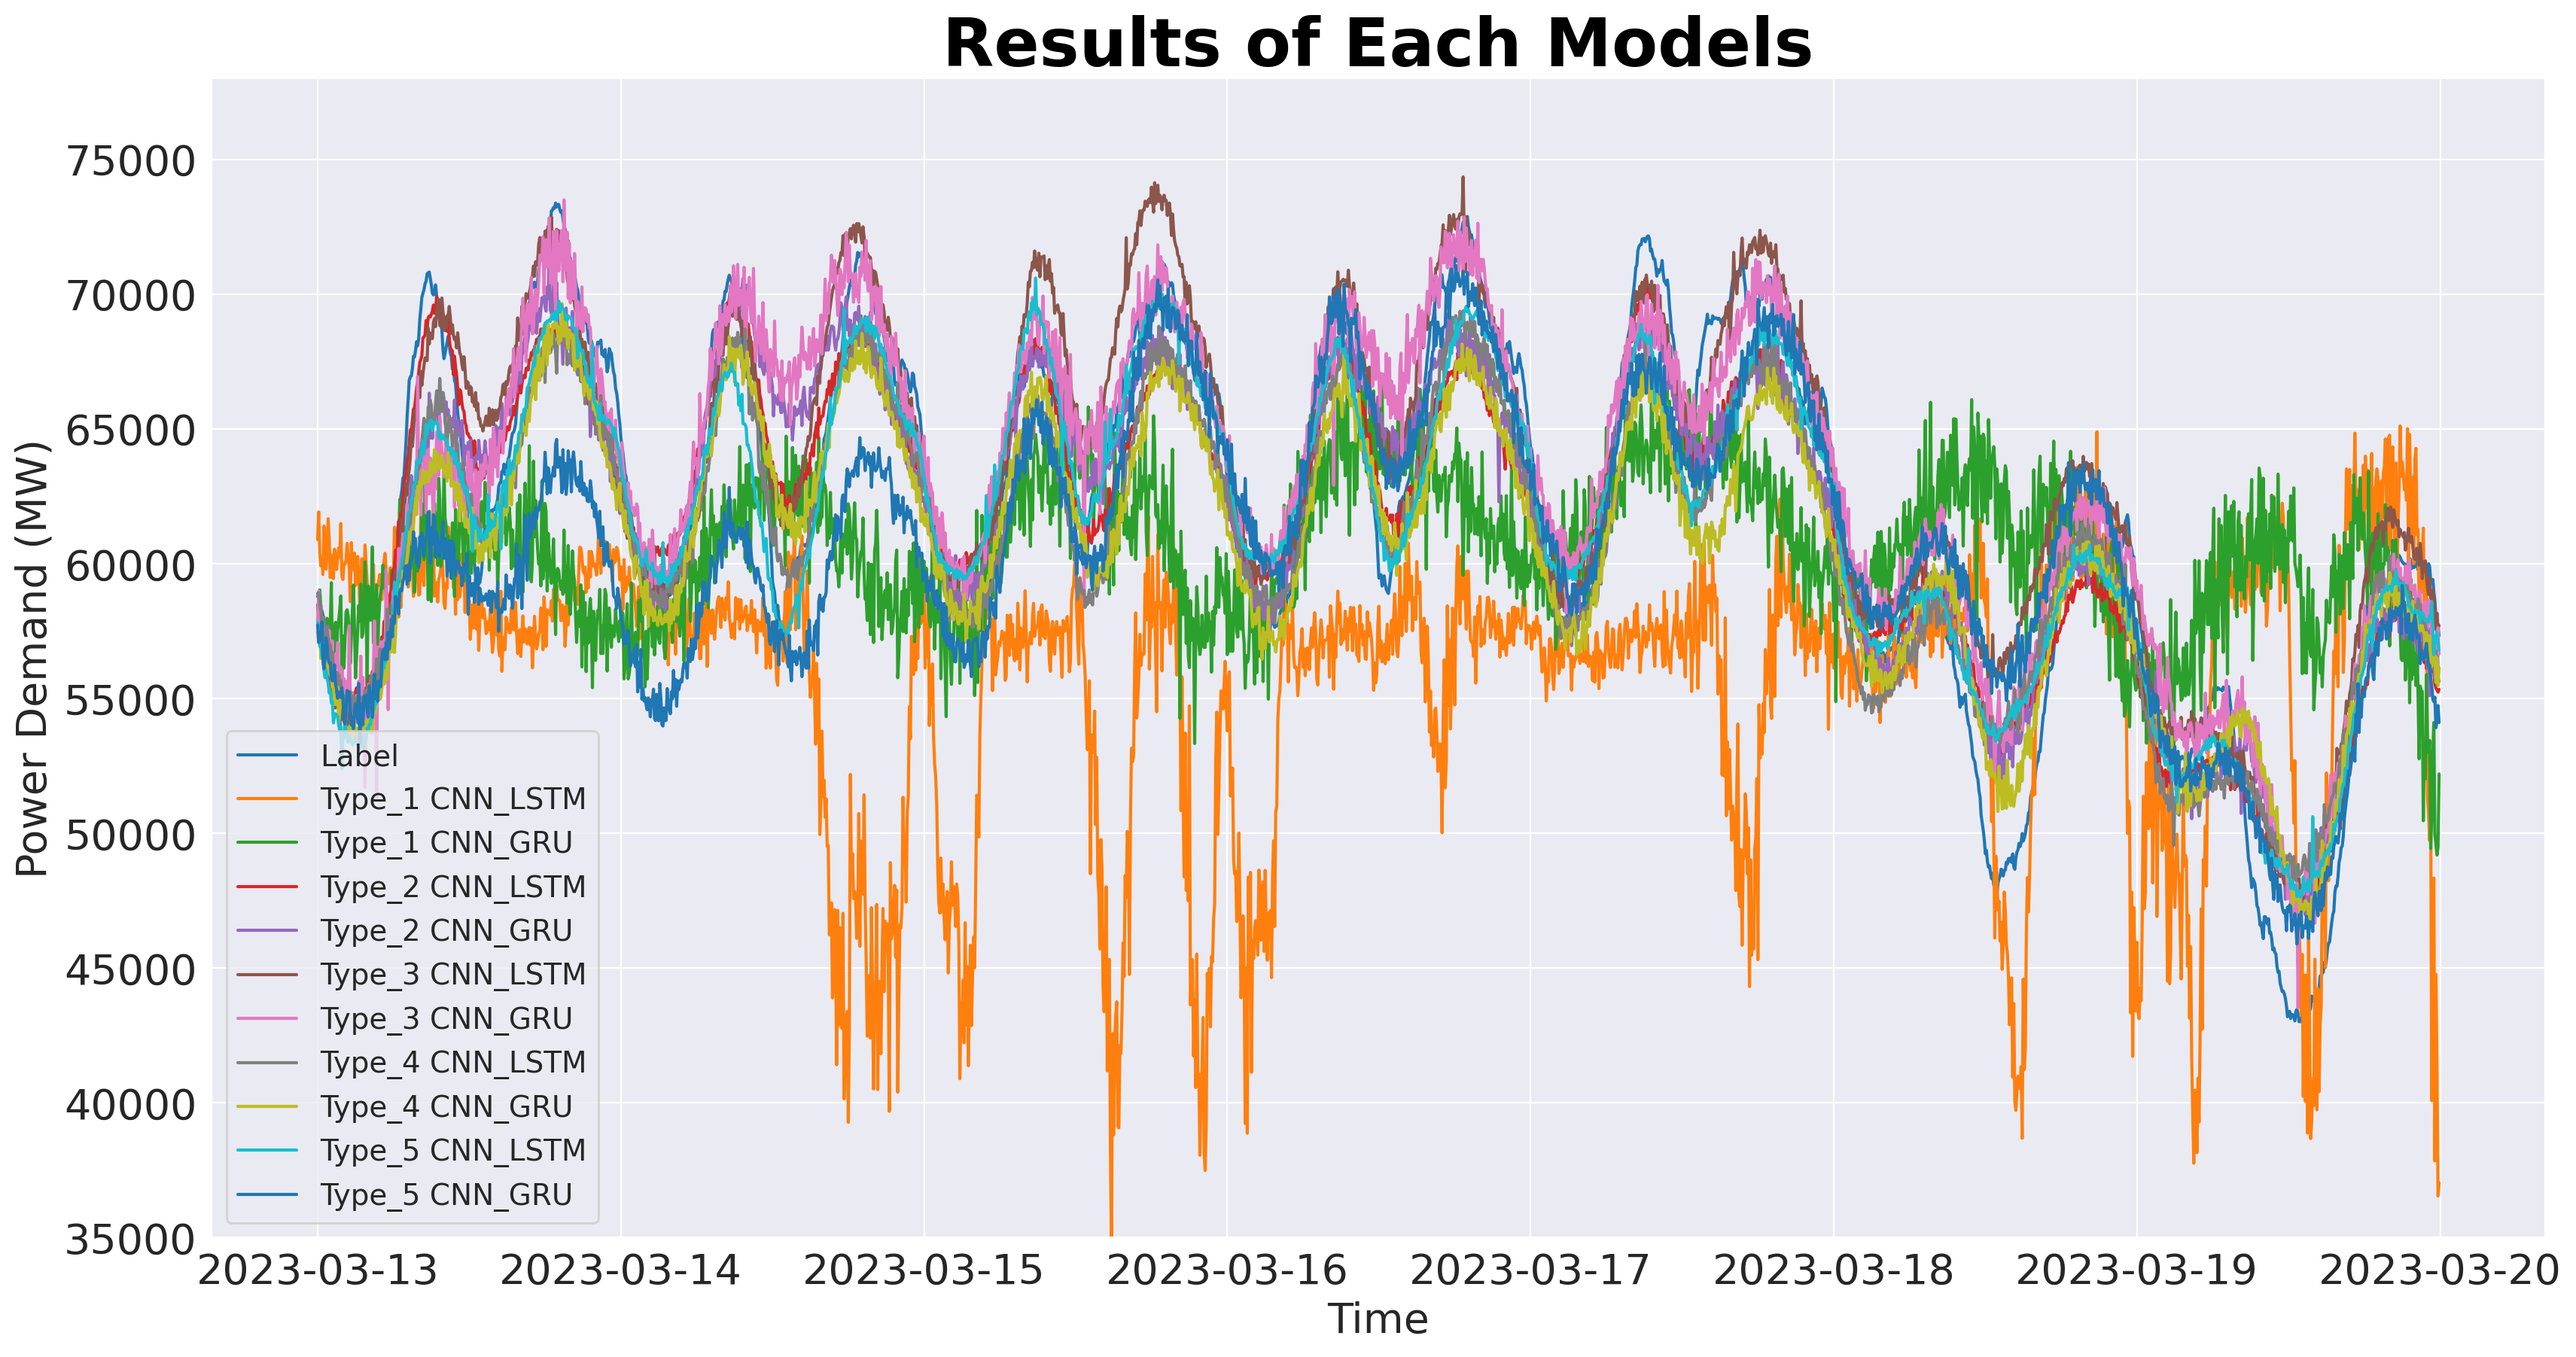

In [32]:
# plt.figure(figsize=(34, 19))
plt.figure(figsize=(20, 10))

plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=50) # figure title 폰트 크기

for result in results.columns[1:]:
    sns.lineplot(data=results, x='Time', y=result, label=result)

font_dict_title = {'family': 'sans-serif',
                    'color':  'Black',
                    'weight': 'bold',
                    'size': 32}

plt.title('Results of Each Models', fontdict=font_dict_title)
plt.legend(loc='lower left', prop={'family':'sans-serif', 'size':14})
plt.ylim([35000, 78000])
plt.ylabel('Power Demand (MW)')
plt.show()

### ***TOP3***

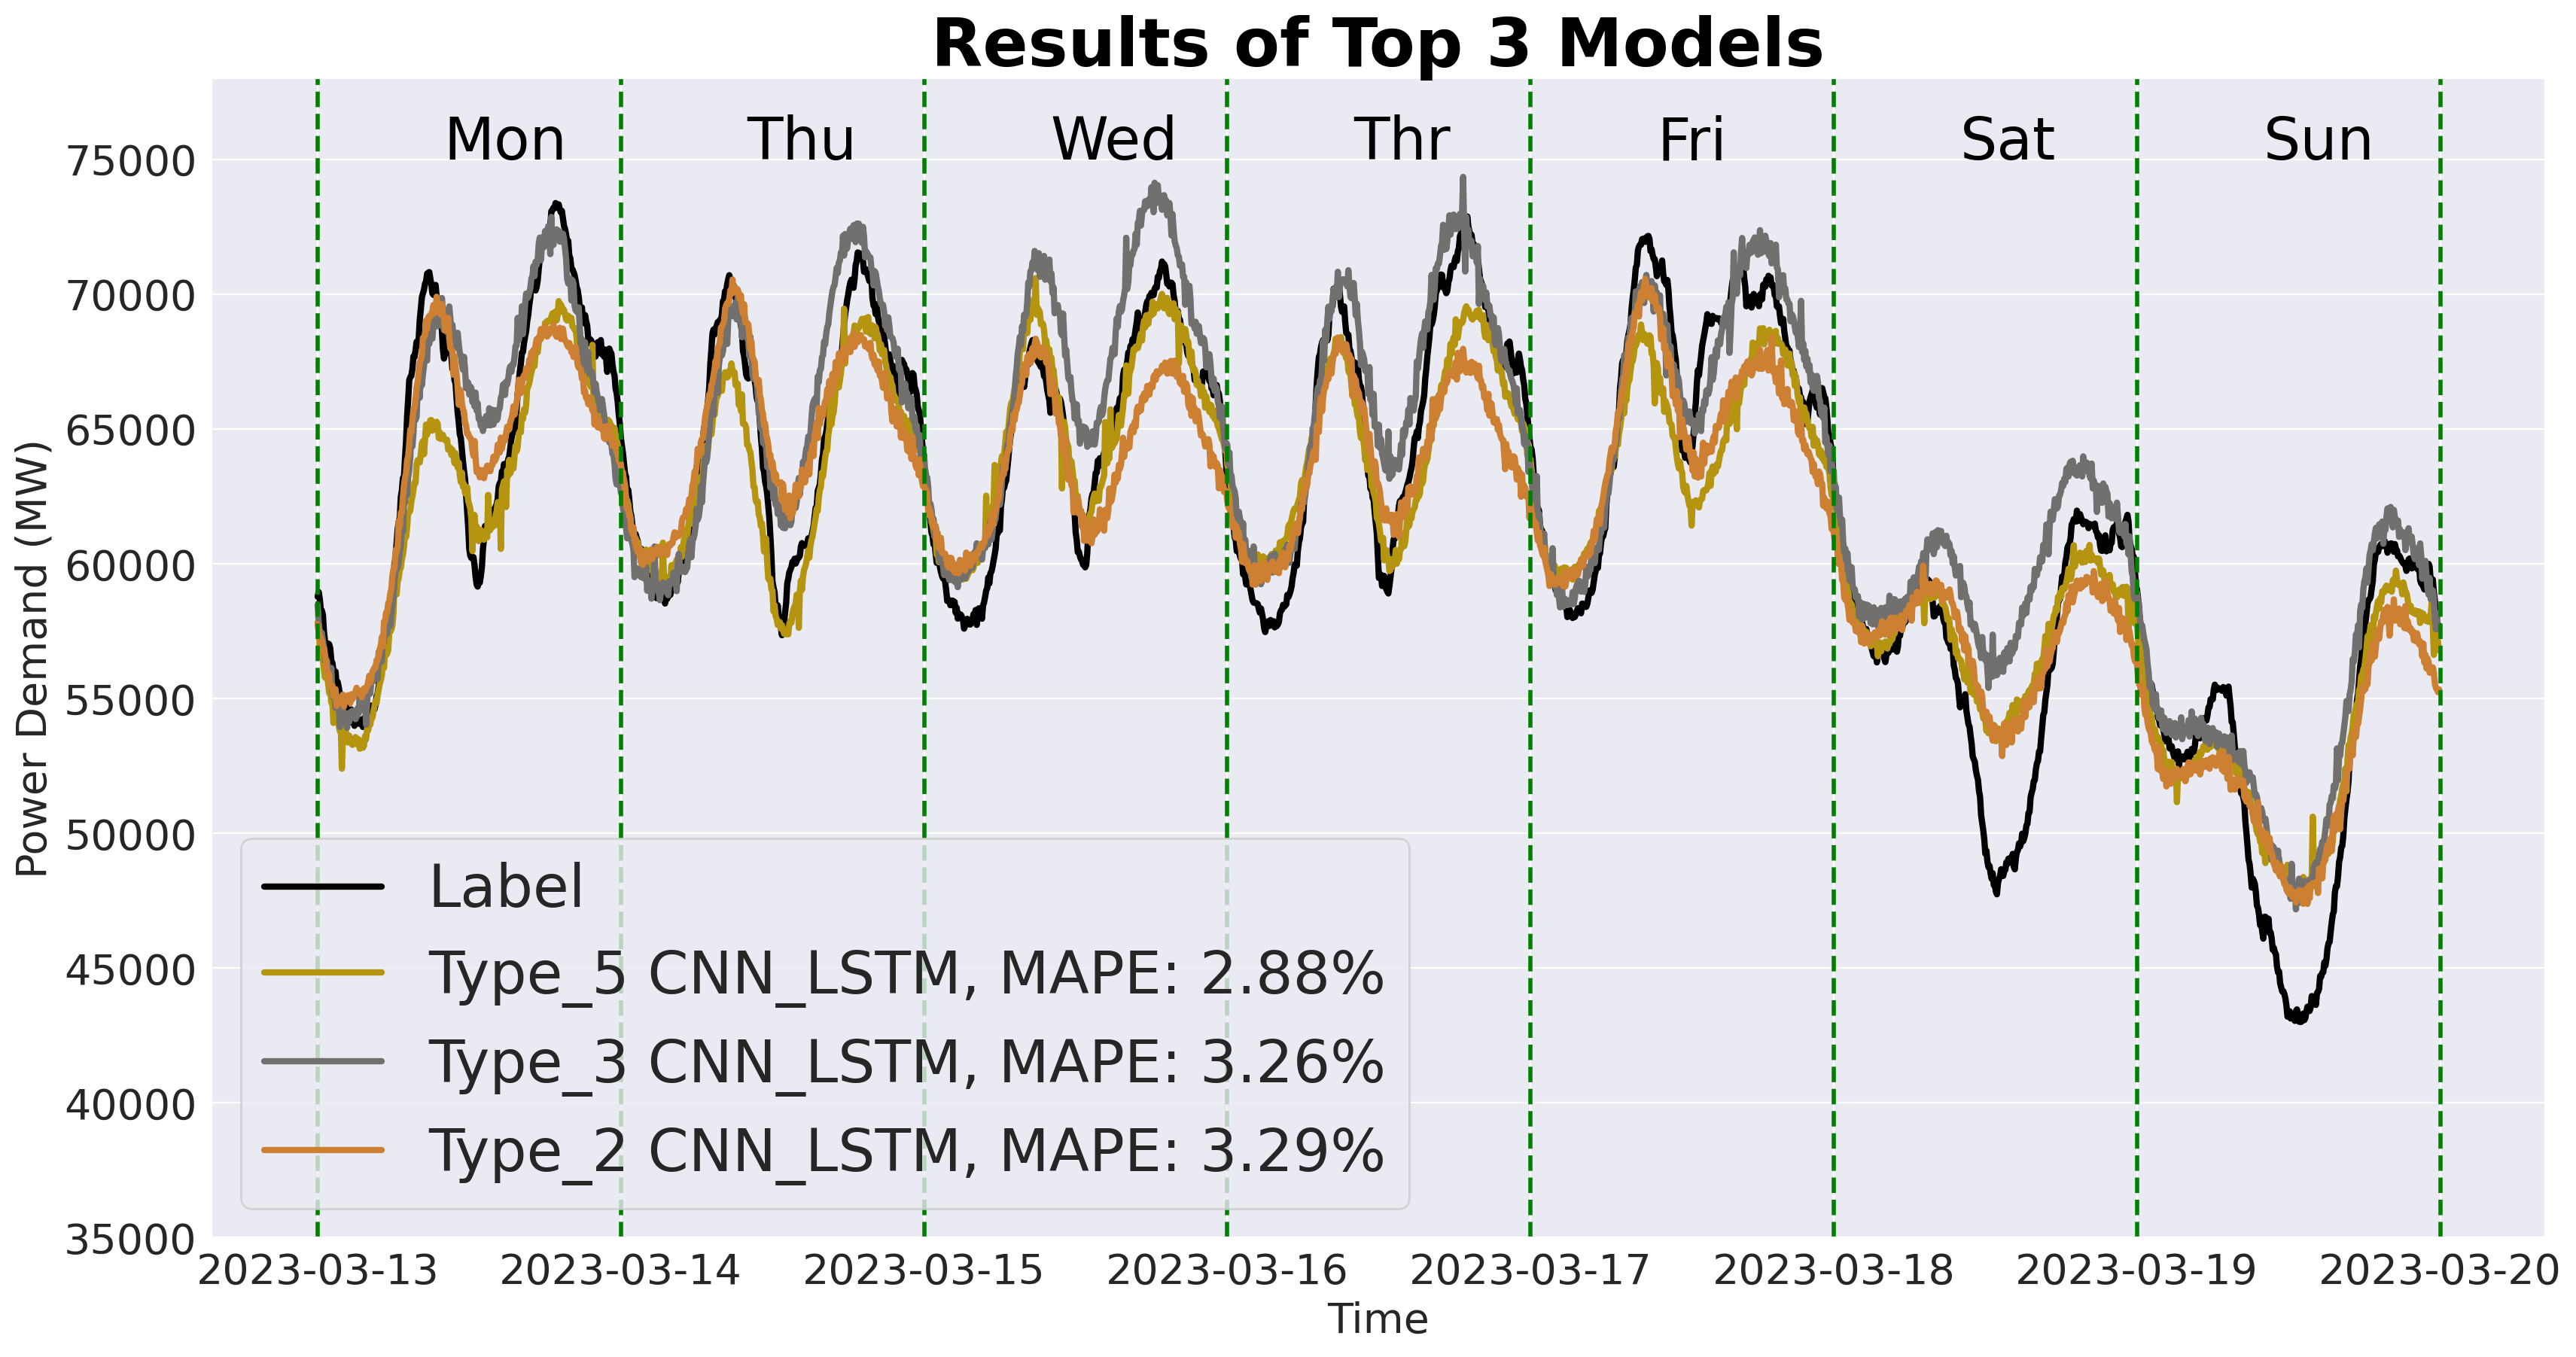

In [33]:
top3_Models = ['Label', 'Type_5 CNN_LSTM', 'Type_3 CNN_LSTM', 'Type_2 CNN_LSTM']
color_list = ['black', '#B59410', '#71706E', '#cd7f32']
mape_list = [0, round(sum(cnn_bilstm_MAPE_list_val_Type_5)/len(cnn_bilstm_MAPE_list_val_Type_5) * 100, 2), round(sum(cnn_bilstm_MAPE_list_val_Type_3)/len(cnn_bilstm_MAPE_list_val_Type_3) * 100, 2), round(sum(cnn_bilstm_MAPE_list_val_Type_2)/len(cnn_bilstm_MAPE_list_val_Type_2) * 100, 2)]
linewidth = [3, 3, 3, 3]

font_dict_title = {'family': 'sans-serif',
                    'color':  'Black',
                    'weight': 'bold',
                    'size': 32}
        
font_dict = {'family': 'sans-serif',
            'color':  'Black',
            'weight': 'normal',
            'size': 28}

# plt.figure(figsize=(34, 19))
plt.figure(figsize=(20, 10))

plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=50) # figure title 폰트 크기

for i, model in enumerate(top3_Models):
  if i == 0:
    sns.lineplot(data=results, x='Time', y=model, label=model, color=color_list[i], lw=linewidth[i])
  else:
    sns.lineplot(data=results, x='Time', y=model, label=f"{model}, MAPE: {mape_list[i]}%", color=color_list[i], lw=linewidth[i])

plt.axvline(pd.to_datetime('2023-03-13 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-13 10:00:00'), 75000, 'Mon', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-14 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-14 10:00:00'), 75000, 'Thu', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-15 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-15 10:00:00'), 75000, 'Wed', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-16 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-16 10:00:00'), 75000, 'Thr', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-17 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-17 10:00:00'), 75000, 'Fri', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-18 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-18 10:00:00'), 75000, 'Sat', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-19 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-19 10:00:00'), 75000, 'Sun', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-20 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.ylim([35000, 78000])
plt.title('Results of Top 3 Models', fontdict=font_dict_title)
plt.ylabel('Power Demand (MW)')
plt.legend(loc='lower left', prop={'family':'sans-serif', 'size':28})

plt.show()


### **Type_2&KPX**

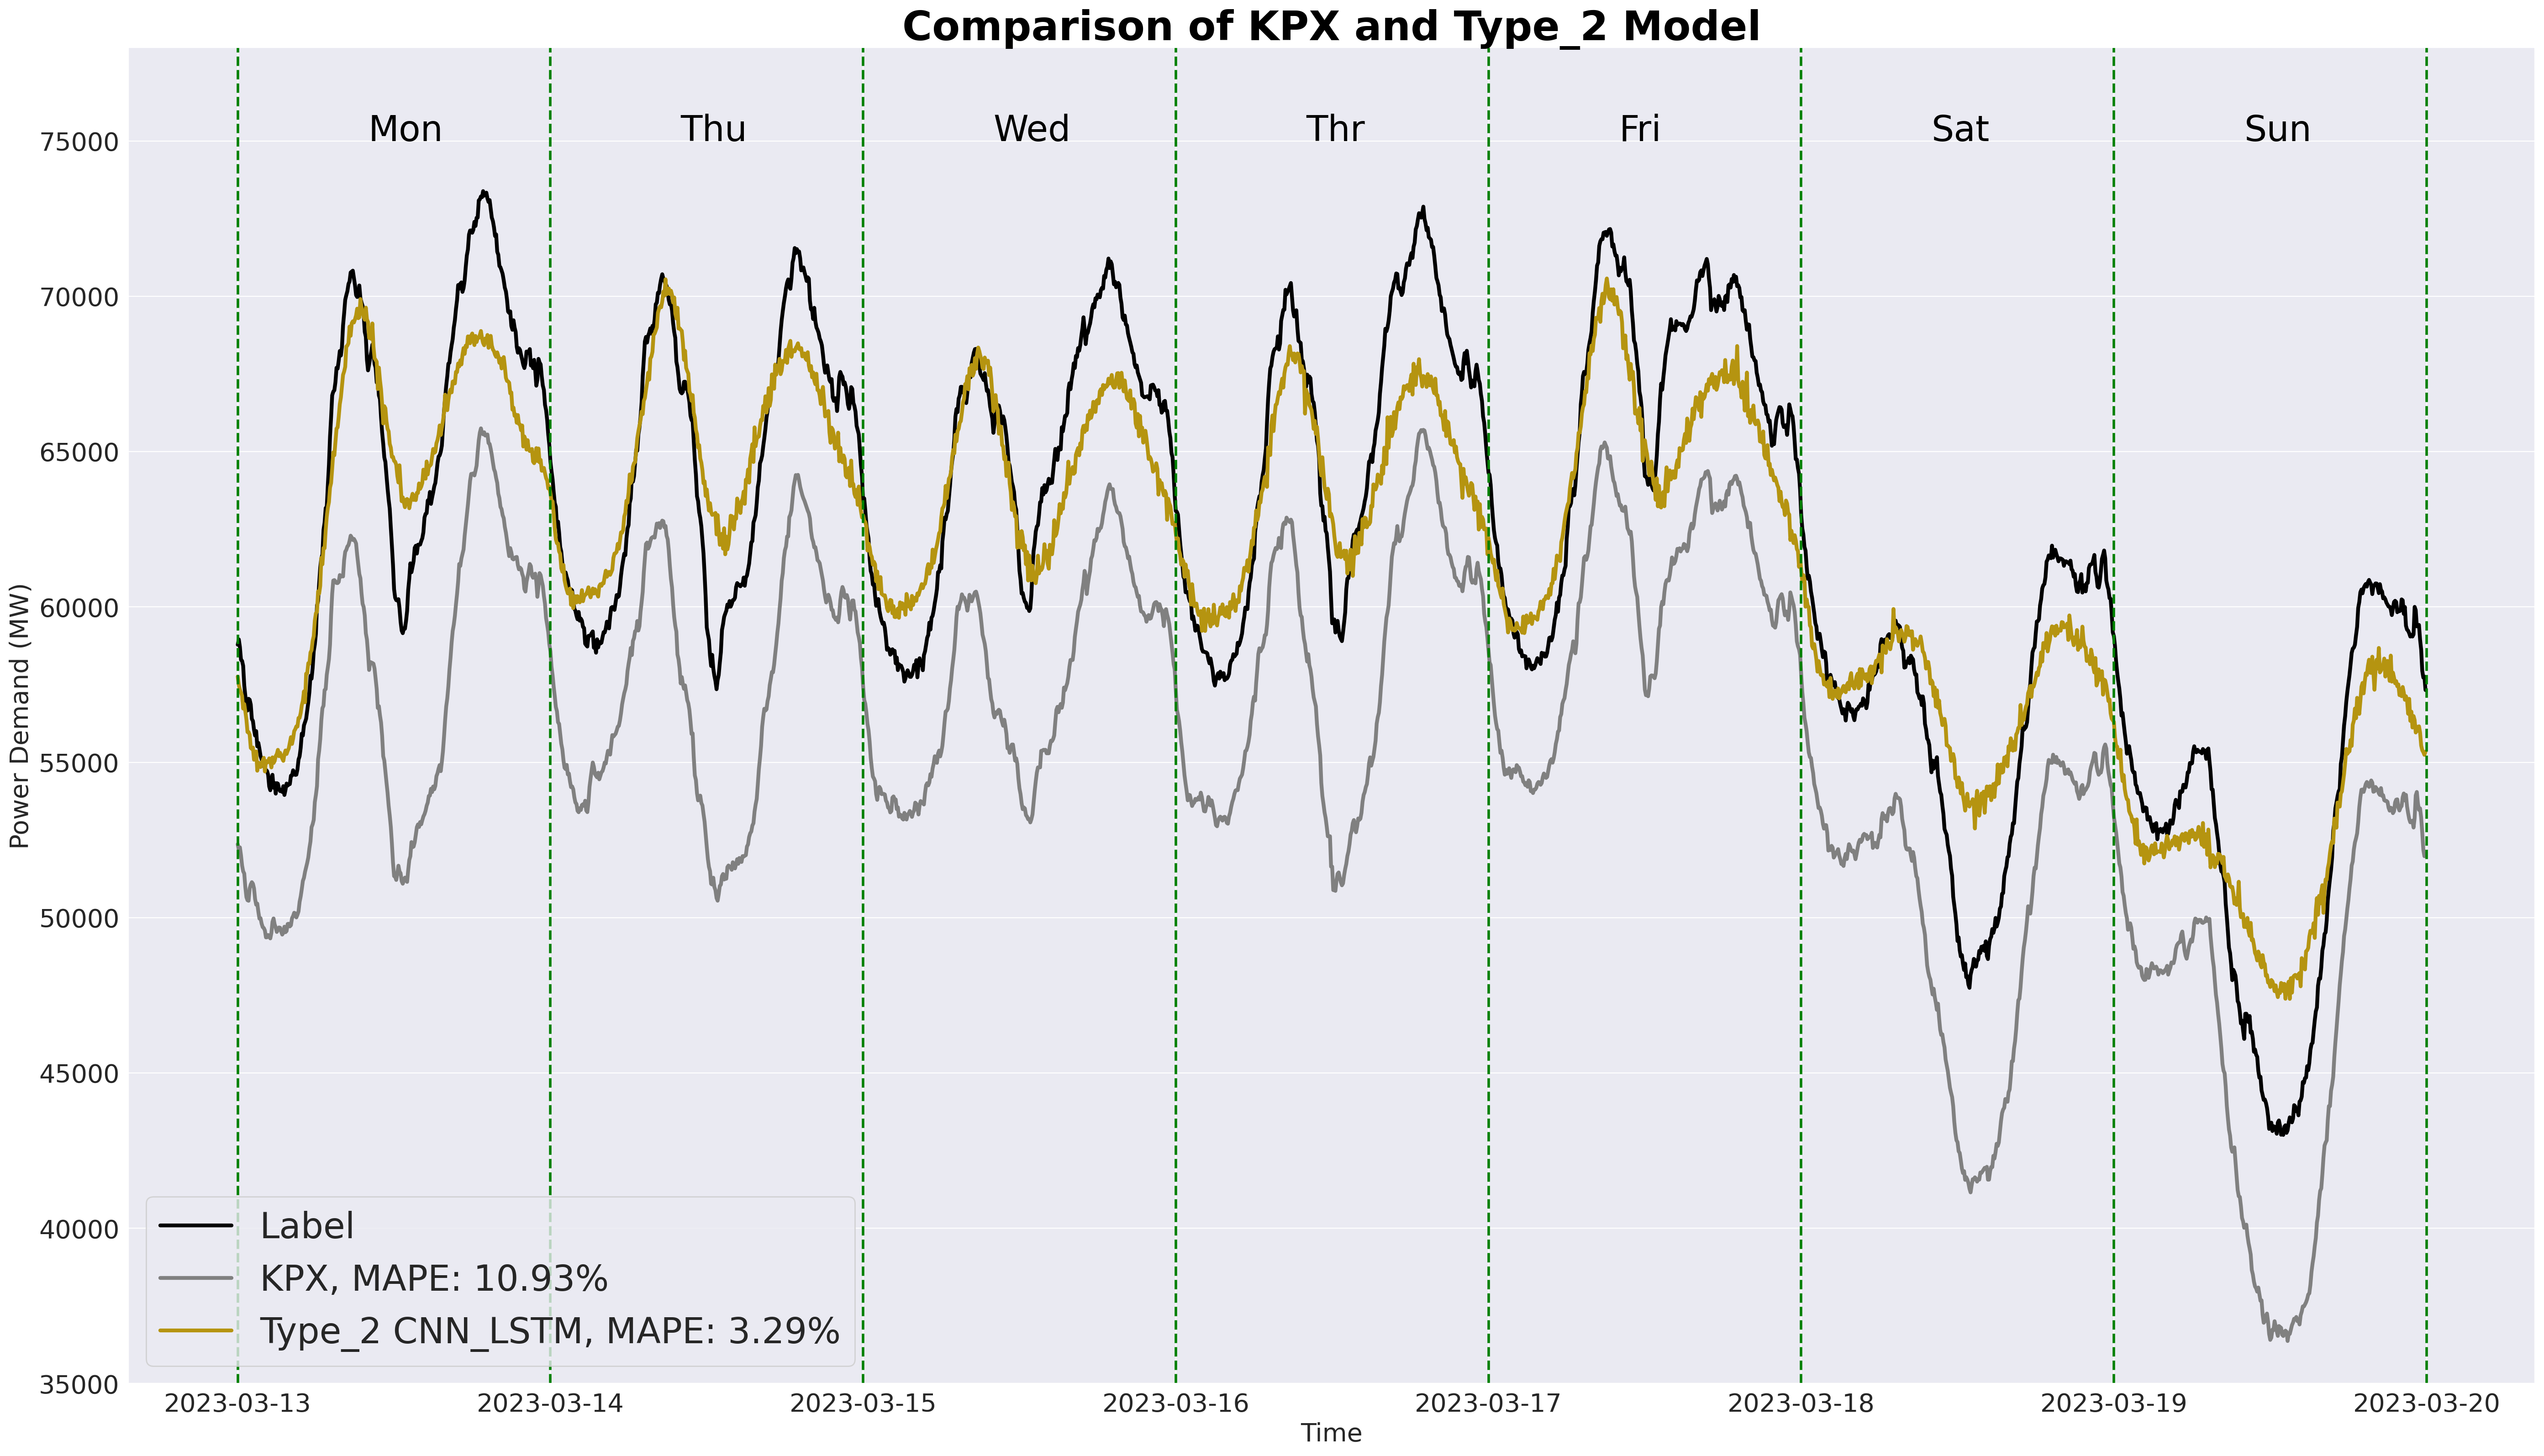

In [48]:
kpx = pd.read_csv(".Final_data/kpx_data.csv")
results = pd.concat([results, kpx['KPX']], axis=1)

optimized_model = ['Label', 'KPX', 'Type_2 CNN_LSTM']
color_list = ['black', 'grey', '#B59410']
linewidth = [3, 3, 3]
10.930
mape_list = [10.930, round(sum(cnn_bilstm_MAPE_list_val_Type_2)/len(cnn_bilstm_MAPE_list_val_Type_2) * 100, 2)]

font_dict_title = {'family': 'sans-serif',
                    'color':  'Black',
                    'weight': 'bold',
                    'size': 32}
        
font_dict = {'family': 'sans-serif',
            'color':  'Black',
            'weight': 'normal',
            'size': 28}

plt.figure(figsize=(34, 19))
for i, model in enumerate(optimized_model):
  if i == 0:
    sns.lineplot(data=results, x='Time', y=model, label=model, color=color_list[i], lw=linewidth[i])
  else:
    sns.lineplot(data=results, x='Time', y=model, label=f"{model}, MAPE: {mape_list[i-1]}%", color=color_list[i], lw=linewidth[i])

plt.axvline(pd.to_datetime('2023-03-13 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-13 10:00:00'), 75000, 'Mon', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-14 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-14 10:00:00'), 75000, 'Thu', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-15 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-15 10:00:00'), 75000, 'Wed', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-16 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-16 10:00:00'), 75000, 'Thr', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-17 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-17 10:00:00'), 75000, 'Fri', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-18 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-18 10:00:00'), 75000, 'Sat', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-19 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('2023-03-19 10:00:00'), 75000, 'Sun', fontdict=font_dict)
plt.axvline(pd.to_datetime('2023-03-20 00:00:00'), 0, 1, color='green', linestyle='--', linewidth=2)
plt.ylim([35000, 78000])
plt.title('Comparison of KPX and Type_2 Model', fontdict=font_dict_title)
plt.ylabel('Power Demand (MW)')
plt.xlabel('Time')
plt.legend(loc='lower left', prop={'family':'sans-serif', 'size':28})
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=50) # figure title 폰트 크기
plt.show()